In [6]:
print('..running')
import os
import torch
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import yaml
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#from util import 
import models
from train import evaluation, training 
from data import load_data
from neural_networks import nnetts

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_dir = 'results_made/test'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'made'

batch_size = 64
D = 784   # input dimension
M = 8000  # hidden layer dimensionality
lr = 1e-3 # learning rate
num_epochs = 85
max_patience = num_epochs//10 # Early Stopping
lam = 0. # Regularization Hyperparameter
n_masks = 1
hyperparameters = {'D': D, 
                   'M': M,
                   'lr': lr,
                   'n_masks': n_masks,
                   'num_epochs': num_epochs,
                   'max_patience': max_patience,
                   'batch_size': batch_size,
                   'lambda': lam,
                    }
with open(result_dir + '/hyperparameters.yaml', 'w') as file:
    yaml.dump(hyperparameters, file)

# Create data loaders
train_data, val_data, test_data = load_data('mnist', binarize = True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

..running


In [7]:
model = models.MADE(input_dim=784, hidden_dims=[M], n_masks=n_masks).to(device)
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad == True], lr = 1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

def loss_fn(x, _, preds):
        batch_size = x.shape[0]
        x, preds = x.view((batch_size, -1)), preds.view((batch_size, -1))
        loss = F.binary_cross_entropy_with_logits(preds, x, reduction="none")
        return loss.sum(dim=1).mean()
# Training procedure
nll_val = training(name=name, result_dir=result_dir, max_patience=max_patience, num_epochs=num_epochs, model=model, loss_fn=loss_fn, optimizer=optimizer,
                   scheduler=scheduler, training_loader=train_loader, val_loader=val_loader, device=device, lam=lam)

Epoch: 0, train nll=103.11278533935547, val nll=1.519874454498291
saved!


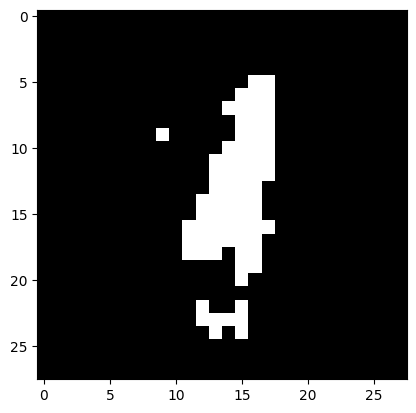

In [5]:
import matplotlib.pyplot as plt
import numpy as np

model_best = torch.load(result_dir + '/' + name + '.model')
model_best.eval()
num_x, num_y = 1, 1
x = model_best.sample(num_x * num_y).detach().numpy()
plottable_image = np.reshape(x, (28, 28))
plt.imshow(plottable_image, cmap='gray')